# Per Frame, are all IDs unique?

In [1]:
%matplotlib inline

import os
import statistics
from collections import Counter
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bb_binary import FrameContainer, Repository

matplotlib.rc("figure", figsize=(12,6))
sns.set_style("white")

repo = Repository("/Users/alexa/Projects/bees-sna/2015/")

In [2]:
detections_per_frame = []
for frame, detection in repo.iter_frames():
    det = []
    for detection in frame.detectionsUnion.detectionsDP:
        det.append(detection.decodedId)
    detections_per_frame.append(det)

In [3]:
print(len(detections_per_frame))

1024


In [42]:
frames_per_delta = [] # delta, number of frames with duplicates, total frames is 1024
all_ids = [] # delta, detected ids in decimal

# Iterate over deltas 0 .. 127
for j in range(128):
    
    ids = set()
    delta = j
    biggerZero = 0
    # Iterate over all frames, should be 1024
    for frame in detections_per_frame:
        
        numbers = []
        # Iterate over detections per frame, different number per frame
        for det in frame:
            
            c = 0
            number = 0
            # Iterate over 12 Bit array
            for i in range(len(det)):
                
                if (det[i] <= 0 + delta):
                    c = c + 1
                if (det[i] >= 255 - delta):
                    c = c + 1
                    number = number + 2**i
            
            # Add detected number in decimal
            if c == 12:
                numbers.append(number)
        
        # Look for duplicates and count them
        mode = stats.mode(numbers).count[0]
        if(mode > 1):
            biggerZero = biggerZero + 1
        
        # Keep ids without the duplicates
        ids.update(set(numbers))
        
    frames_per_delta.append((delta, biggerZero))
    all_ids.append((delta, ids))

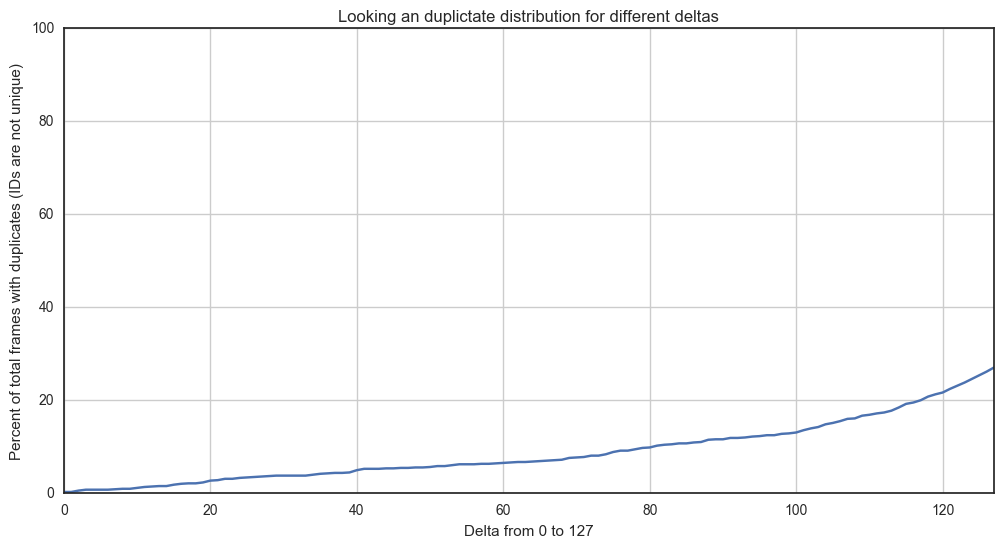

In [43]:
total = len(detections_per_frame)

list = [(elem1, (elem2*100)/total) for elem1, elem2 in frames_per_delta]
plt.plot(*zip(*list))
plt.xlabel('Delta from 0 to 127')
plt.ylabel('Percent of total frames with duplicates (IDs are not unique)')
plt.title('Looking an duplictate distribution for different deltas')
plt.axis([0, 127, 0, 100])
plt.grid(True)

## How many different IDs in total for complete FrameContainer?
It would be nice to see how many unique IDs are detected in each frame. And also what IDs are still in the next frame, what IDs are new and what IDs are missing. So what portion of the bees stay the same from frame to frame.

In [44]:
print(len(all_ids))

128


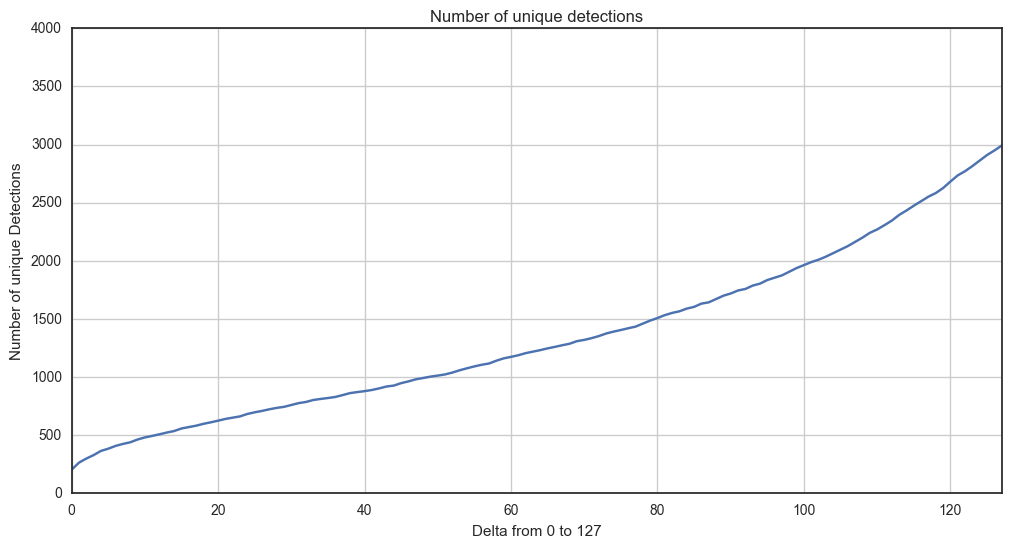

In [47]:
list = [(elem1, len(elem2)) for elem1, elem2 in all_ids]
plt.plot(*zip(*list))
plt.xlabel('Delta from 0 to 127')
plt.ylabel('Number of unique Detections')
plt.title('Number of unique detections')
plt.axis([0, 127, 0, 4000])
plt.grid(True)

## For DELTA=64 (256/4), how many IDs stay the same in succesive frames, how many new ones?

In [50]:
delta = 63
ids = []
for frame in detections_per_frame:

    numbers = set()
    # Iterate over detections per frame, different number per frame
    for det in frame:

        c = 0
        number = 0
        # Iterate over 12 Bit array
        for i in range(len(det)):

            if (det[i] <= 0 + delta):
                c = c + 1
            if (det[i] >= 255 - delta):
                c = c + 1
                number = number + 2**i

        # Add detected number in decimal
        if c == 12:
            numbers.add(number)
    
    ids.append(numbers)

In [58]:
num_ids_per_frame = [(len(elem)) for elem in ids]

a = np.array(num_ids_per_frame)
print("Average: {}".format(np.average(a)))
print("Max: {}".format(np.max(a)))
print("Min: {}".format(np.min(a)))
print("Mean: {}".format(np.mean(a)))
print("Median: {}".format(np.median(a)))
print("Sum: {}".format(np.sum(a)))

Average: 72.2109375
Max: 85
Min: 60
Mean: 72.2109375
Median: 72.0
Sum: 73944


In [61]:
mystats = []

# (numberOfNewElements,numberOfOldElemens)
mystats.append((len(ids[0]),0))

for i in range(len(ids)-2):
    a = ids[i]
    b = ids[i+1]
    
    old = len(set(a).intersection(b))
    new = len(b)-old
    mystats.append((new,old))

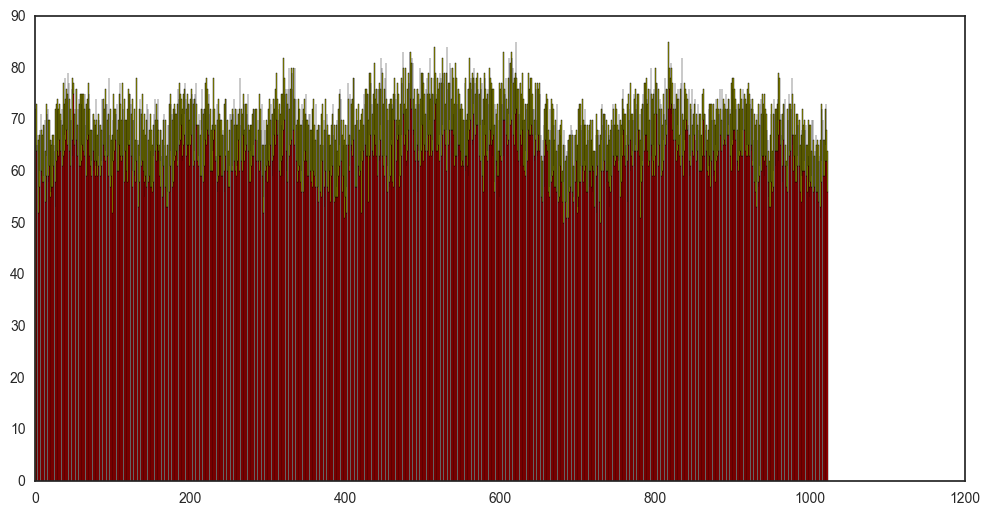

In [88]:
newElems, oldElems = zip(*mystats)

ind = range(len(mystats))    # the x locations for the groups

p1 = plt.bar(ind, oldElems, color='r')
p2 = plt.bar(ind, newElems, color='y', bottom=oldElems)

#plt.ylabel('Scores')
#plt.title('Scores by group and gender')
#plt.xticks(ind + width/2., ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()